# Create an input file - 2D notched plate

In [16]:
import numpy as np
from numba import njit, prange
import matplotlib.pyplot as plt
import sklearn.neighbors as neighbors
import h5py

### Build particle coordinates (2D)

The function ```build_particle_coordinates``` is used to build a rectangular set of particles with regular spacing

In [17]:
def build_particle_coordinates(dx, n_div_x, n_div_y):
    """
    Build particle coordinates
    
    Parameters
    ----------
    
    Returns
    -------

    Notes
    -----
    * Rename as build_plate?
    
    """
    particle_coordinates = np.zeros([n_div_x * n_div_y, 2])
    counter = 0

    for i_y in range(n_div_y):      # Depth
        for i_x in range(n_div_x):  # Length
            coord_x = dx * i_x
            coord_y = dx * i_y
            particle_coordinates[counter, 0] = coord_x
            particle_coordinates[counter, 1] = coord_y
            counter += 1

    return particle_coordinates

### Build a notch

In [18]:
def build_notch(x, bondlist, notch):
    
    n_nodes = np.shape(x)[0]
    n_bonds = np.shape(bondlist)[0]
    
    P1 = notch[0]
    P2 = notch[1]
    
    mask = []
    
    for k_bond in range(n_bonds):

        node_i = bondlist[k_bond, 0]
        node_j = bondlist[k_bond, 1]
        
        P3 = x[node_i]
        P4 = x[node_j]
        
        intersect = determine_intersection(P1, P2, P3, P4)
        
        if intersect == True:
            mask.append(k_bond)
    
    reduced_bondlist = np.delete(bondlist, mask, axis=0)
    n_family_members = rebuild_node_families(n_nodes, reduced_bondlist)
    
    return reduced_bondlist, n_family_members

In [19]:
def determine_intersection(P1, P2, P3, P4):
    """
    Determine if a bond intersects with a notch
        - Given two line segments, find if the 
          given line segments intersect with
          each other.
    
    Parameters
    ----------
    P : 
        P = (x, y)
        
    Returns
    ------
    Returns True if two lines intersect
    
    Notes
    -----
    * This solution is based on the following
      paper:
      
      Antonio, F. (1992). Faster line segment
      intersection. In Graphics Gems III
      (IBM Version) (pp. 199-202). Morgan
      Kaufmann.
    
    """
        
    A = P2 - P1
    B = P3 - P4  
    C = P1 - P3
    
    denominator = (A[1] * B[0]) - (A[0] * B[1])

    alpha_numerator = (B[1] * C[0]) - (B[0] * C[1]) 
    beta_numerator = (A[0] * C[1]) - (A[1] * C[0])
    
    alpha = alpha_numerator / denominator    
    beta = beta_numerator / denominator
    
    if (0 < alpha < 1) and (0 < beta < 1):
        intersect = True
    else:
        intersect = False
        
    return intersect

In [20]:
def rebuild_node_families(n_nodes, bondlist):
    
    n_bonds = np.shape(bondlist)[0]
    n_family_members = np.zeros(n_nodes)
    
    for k_bond in range(n_bonds):

        node_i = bondlist[k_bond, 0]
        node_j = bondlist[k_bond, 1]
        
        n_family_members[node_i] += 1
        n_family_members[node_j] += 1
        
    return n_family_members

### Build particle families

Build a neighbour list of size (n\_nodes $\times$ max(n\_family\_members)). Pad empty cells with -1

$$\textbf{neighbourlist} =
\begin{bmatrix}
   1 & 2 & \dots & -1 \\
   2 & 1 & \dots & -1\\
   \vdots & \vdots & \dots & -1\\
   nnodes & nnodes & \dots & -1
\end{bmatrix}_{\: nnodes \, \times \, max(n\_family\_members)}
$$


In [21]:
def build_particle_families(x, horizon):
    """
    Build particle families

    Parameters
    ----------
    x : ndarray (float)
        Material point coordinates in the reference configuration

    horizon : float
        Material point horizon (non-local length scale)

    Returns
    -------
    nlist : list of numpy arrays (int)

    Notes
    -----

    """
    n_nodes = np.shape(x)[0]

    tree = neighbors.KDTree(x, leaf_size=160)
    neighbour_list = tree.query_radius(x, r = horizon)

    # Remove identity values, as there is no bond between a node and itself
    neighbour_list = [neighbour_list[i][neighbour_list[i] != i] for i in range(n_nodes)]

    n_family_members = [len(neighbour_list[i]) for i in range(n_nodes)]
    n_family_members = np.array(n_family_members, dtype = np.intc)

    nlist = np.ones((n_nodes, n_family_members.max()), dtype=np.intc) * -1
    
    for i in range(n_nodes):
        nlist[i, :n_family_members[i]] = neighbour_list[i]

    nlist = nlist.astype(np.intc)

    return nlist, n_family_members

### Build bond list

Build a bond list of size (n\_bonds $\times$ 2).

$$\textbf{bondlist} =
\begin{bmatrix}
   1 & 2 \\
   1 & 3 \\
   1 & 4 \\
   \vdots & \vdots \\
   nbonds & -
\end{bmatrix}_{\: nbonds \, \times \, 2}
$$

In [22]:
def build_bond_list(nlist):
    """
    Build bond list
    """
    bondlist = [[i, j] for i, neighbours in enumerate(nlist) for j in neighbours if i < j]
    bondlist = np.array(bondlist, dtype=np.intc)
    
    return bondlist

### Define boundary conditions

This won't work as is. Say for a node that ```bc_flag = 1``` and ```bc_unit_vector = 0```, then that node is constrained

* Applied displacement
    * Flag (1 - the node is subject to a boundary condition, 0 - no boundary condition)
    * Direction (unit vector)
    * Magnitude
* Applied force
    * Flag
    * Direction (unit vector)
    * Magnitude
* Constraint

In [39]:
def build_boundary_conditions(particles, dx):
    
    bc_flag = np.zeros((len(particles), 2), dtype=np.intc)
    bc_unit_vector = np.zeros((len(particles), 2), dtype=np.intc)

    tol = 1e-6
    
    for i, particle in enumerate(particles):
        if particle[1] < (0.02 + tol):
            bc_flag[i, 1] = 1
            bc_unit_vector[i, 1] = -1
        if particle[1] > (0.23 - dx - tol):
            bc_flag[i, 1] = 1
            bc_unit_vector[i, 1] = 1

    return bc_flag, bc_unit_vector

### Calculate partial volume correction factors (to improve spatial integration accuracy)

### Calculate surface correction factors (to correct the peridynamic surface effect)

### Constitutive model / calculate bond stiffness

In [24]:
def calculate_bond_stiffness(E, t, horizon):
    """
    Bond stiffness
        - linear elastic model
        - 2D
        - plane stress
        
    Parameters
    ----------

    Returns
    -------

    Notes
    -----

    """
    c = (9 * E) / (np.pi * t * horizon**3)
    
    return c

In [25]:
def calculate_critical_stretch(G_F, E, horizon):
    """
    Critical stretch
        - linear elastic model
        - 2D
        
    Parameters
    ----------

    Returns
    -------

    Notes
    -----

    """
    sc = np.sqrt((4 * np.pi * G_F) / (9 * E * horizon))
    
    return sc

### Calculate stable time step

In [26]:
def calculate_stable_time_step():
    """
    Calculate the minimum stable time step
    """
    pass
    

### Save input file as a HDF5 file

[Good Usability Practices in Scientific Software Development](https://arxiv.org/pdf/1709.00111.pdf)
* Using input and configuration files is defined as one of nine aspects of good usability

In [27]:
def save_input_file(filename, **kwargs):
    """
    Save an input file to be loaded by the simulation module
    """
    for key, values in kwargs.items():
        write_array(filename, key, values)
    

In [28]:
def write_array(write_path, dataset, array):
    """
    Write an array to a HDF5 file
    
    Parameters
    ----------
    write_path : str
        Path to write the HDF5 file
    dataset : str
        Name of the dataset saved in the HDF5 file
    array : ndarray
        Array to be saved

    Returns
    -------
    
    Notes
    -----
    'a' - Read/write if exists, create otherwise

    """
    with h5py.File(write_path, 'a') as h5file:
        h5file.create_dataset(dataset,  data=array)

### Build input file

/var/folders/64/_tlnxd_n5k5739305p7102yh0000gn/T/ipykernel_20565/3478352351.py:38: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = alpha_numerator / denominator
/var/folders/64/_tlnxd_n5k5739305p7102yh0000gn/T/ipykernel_20565/3478352351.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  beta = beta_numerator / denominator


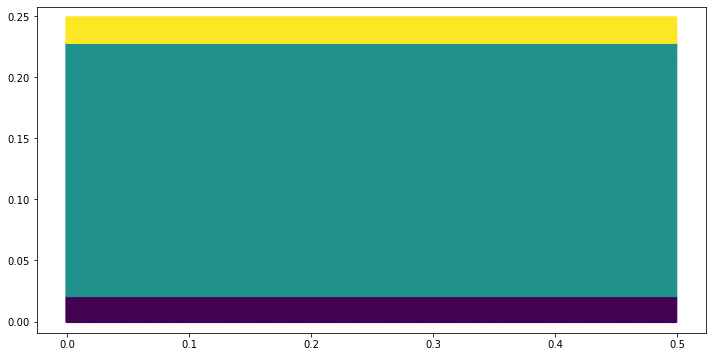

In [43]:
def build_input_file():
    
    dx = 1.25E-3
    n_div_x = np.rint(0.5 / dx).astype(int)
    n_div_y = np.rint(0.25 / dx).astype(int)
    horizon = np.pi * dx
    cell_volume = dx**2
    E = 4.55E9
    G_F = 38.46
    density = 1230
    t = dx
    notch = [np.array([0 - dx, 0.125 - (dx/2)]), np.array([0.2, 0.125 - (dx/2)])]
    
    x = build_particle_coordinates(dx, n_div_x, n_div_y)    
    nlist, n_family_members = build_particle_families(x, horizon)
    bondlist = build_bond_list(nlist)
    bondlist, n_family_members = build_notch(x, bondlist, notch)
    bc_flag, bc_unit_vector = build_boundary_conditions(x, dx)
    
    c = calculate_bond_stiffness(E, t, horizon)
    sc = calculate_critical_stretch(G_F, E, horizon)
    
    save_input_file('2D_notch.h5', x=x, bondlist=bondlist, 
                    n_family_members=n_family_members,
                    bc_flag=bc_flag, bc_unit_vector=bc_unit_vector,
                    c=c, sc=sc, density=density, cell_volume=cell_volume)
    
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    ax.scatter(x[:,0], x[:,1], s=5, c=bc_unit_vector[:,1])
    plt.axis('equal')

build_input_file()